# Intercomparison Campaigns - Interpolate Data

**Contains modified Copernicus Climate Change Service Information 2020**
under [License](https://apps.ecmwf.int/datasets/licences/copernicus/)

*Copernicus Climate Change Service (C3S) - Upper Air Data Service (2020)*

The purpose of this IPython Notebook is to demonstrate the usability of data from intercomparison campaigns.

    Author: U. Voggenberger
    Date: 09.2020
    Contact: ulrich.voggenberger [at] univie.ac.at
    License: C3S, 2020

In [1]:
import pandas
import numpy as np
import datetime
import glob
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import cdsapi, zipfile, os, time

# Please note: Server URL will be omitted, once published
c = cdsapi.Client(url='https://sis-dev.climate.copernicus.eu/api/v2')
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings("ignore")

In [2]:
plt.rcParams['figure.figsize'] = (10,10)
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

In [3]:
def convert(s):
    # initialization of string to ""
    new = ""
    # traverse in the string 
    for x in s:
        new += x.decode() 
    # return string 
    return new

## Accessing data :

We will interpolate pressure data to compare different sondes, which were all mounted onto the same balloon. <br>
It's not necessary to select the data with the help of 'ListProfiles.xls' - a file for mapping the data of the different sondes to one ascent. <br>
Opening all available data and searching for the matching report_id would be possible too, we want to show you that it's not necessary to load all the data before computing. <br> <br>


__Consider that there is no height information matching the pressure values on early radiosondes.__ <br> <br>


We will select a reference sonde, based on the longest series of measurements.<br>
The pressure data of our reference sonde will be interpolated onto the time - minutes since the ascent start.<br>
With the resulting interpolation funktion we can get the exact moment, when the sonde were on a standard pressure level.<br>
In the second step we will get the pressure value of all the other sondes to that given time. For this process it's necessary to interpolate backwards: time onto pressure.<br>


### First we request a file from the intercomparison campagne to have a look at it:

In [4]:
import sys
sys.path.append(os.getcwd()+'/../cds-backend/code/')
import cds_eua3 as eua

r = c.retrieve('insitu-comprehensive-upper-air-observation-network',
                       {
                           'variable': ["air_temperature"],
                           'overwrite': True,
                           'statid': '0-20100-0-00403',
                           'period': '19001001/20201231',
                           'optional': ['sonde_type'],
                           'cdm': ['sensor_configuration/comments', 'sensor_configuration/sensor_id'],
                       })
if True:
        # Start Download
        r.download(target='download.zip')
        # Check file size
        assert os.stat('download.zip').st_size == r.content_length, "Downloaded file is incomplete"
        # Unzip the Data Stream
        z = zipfile.ZipFile('download.zip')
        z.extractall(path='./example_data/6/')
        z.close()
        os.remove('download.zip')

file = glob.glob('./example_data/6/*')[0]


2021-06-22 14:56:08,550 INFO Welcome to the CDS
2021-06-22 14:56:08,552 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-06-22 14:56:08,787 INFO Request is completed
2021-06-22 14:56:08,788 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data2/adaptor.comprehensive_upper_air.retrieve-1624366408.9184244-4038-15-ea868150-9578-4028-9f00-f64be97b8fd0.zip to download.zip (705K)
2021-06-22 14:56:09,157 INFO Download rate 1.9M/s 


### We open it and look at the data structure:

In [5]:
try:
    with eua.CDMDataset(file) as data:
        display(data)
        df = data.to_dataframe(variables=['lat', 'lon', 'plev', 'report_id', 'sonde_type', 'ta', 'time', 'trajectory_index'])
except:
    pass

File: <HDF5 file "dest_0-20100-0-00403_air_temperature.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 0.69 MB
Filename: ./example_data/6/dest_0-20100-0-00403_air_temperature.nc
(G)roups/(V)ariables: 

 - V | lat__________________________________________ : : (1030,)
 - V | lon__________________________________________ : : (1030,)
 - V | plev_________________________________________ : : (1030,)
 - V | report_id____________________________________ : : (1030, 19)
 - G | sensor_configuration_________________________ : : 2
 - V | sonde_type___________________________________ : : (1030, 11)
 - V | ta___________________________________________ : : (1030,)
 - V | time_________________________________________ : : (1030,)
 - V | trajectory_index_____________________________ : : (1030,)
 - V | trajectory_label_____________________________ : : (17, 19)

2021-06-22 14:56:18,243 INFO Reading Profile on slice(None, None, None)


In [6]:
df

,lat,lon,plev,report_id,sonde_type,ta,time,trajectory_index
0,46.812,6.942,2700.0,0-20100-0-00403-000,"IF1,IF2,IFA",222.05,1779875160,0
1,46.812,6.942,2800.0,0-20100-0-00403-000,"IF1,IF2,IFA",221.95,1779875100,0
2,46.812,6.942,3000.0,0-20100-0-00403-000,"IF1,IF2,IFA",221.65,1779875040,0
3,46.812,6.942,3200.0,0-20100-0-00403-000,"IF1,IF2,IFA",221.55,1779874980,0
4,46.812,6.942,3400.0,0-20100-0-00403-000,"IF1,IF2,IFA",221.65,1779874920,0
...,...,...,...,...,...,...,...,...
1025,46.812,6.942,86500.0,0-20100-0-00403-055,"IF1,IF2,IFA",278.65,1781478420,16
1026,46.812,6.942,89000.0,0-20100-0-00403-055,"IF1,IF2,IFA",279.75,1781478360,16
1027,46.812,6.942,91500.0,0-20100-0-00403-055,"IF1,IF2,IFA",280.75,1781478300,16
1028,46.812,6.942,94000.0,0-20100-0-00403-055,"IF1,IF2,IFA",282.65,1781478240,16


### To look up the sonde type we can have a look in 'sensor_configuration/sensor_id' and 'sensor_configuration/comments':

In [30]:
with eua.CDMDataset(file) as data:
    sid = data.to_dataframe(groups='sensor_configuration', variables=['sensor_id', 'comments'])
sid

2021-06-22 15:24:06,342 INFO Reading Profile on slice(None, None, None)


,sensor_id,comments
0,???,??? Unknown instrument category because data is not available for checking^
1,AA3,"AA3 Australia Astor 72 MHz thermistor in S-shaped duct radiosonde {<= 1953}^ (I=K including 72 and 403 MHz, T=087)"
2,AA4,"AA4 Australia Astor 72 MHz external thermistor radiosonde {1962}^ (I=K including 72 and 403 MHz, T=087) <F=V72AB,P=A,T=TR,U=L>"
3,AA5,"AA5 Australia Astor 403 MHz thermistor in duct radiosonde {<= 1953}^ (I=K including 72 and 403 MHz, T=090) <F=V403FB,P=A,T=TRd,U=L>"
4,AA6,"AA6 Australia Astor Type 403 (402 MHz) external thermistor radiosonde {1962}^ (T=088) <F=V402FB,P=A,T=TR,U=L>"
...,...,...
3290,APA3,APA3 exact type insufficiently documented
3291,A??,A?? exact type insufficiently documented
3292,A???,A??? exact type insufficiently documented
3293,C[,C[ exact type insufficiently documented


In [20]:
sensors = df.iloc[0].sonde_type.split(',')
sensors

['IF1', 'IF2', 'IFA']

In [29]:
pandas.set_option('display.max_colwidth', -1)
for i in sensors:
    display(sid[sid.sensor_id == i])

,sensor_id,comments
458,IF1,"IF1 India fan drive 75 MHz radiosonde {1940s}^ <F=V75HR(paper fan),P=A,T=BC,U=W>"


,sensor_id,comments
459,IF2,"IF2 India fan drive 2-transmitter 75 and 397 MHz radiosonde {1957}^ (I=N2) <F=V75+397HR(paper fan),P=A,T=BC,U=W>"


,sensor_id,comments
460,IFA,"IFA India fan drive single 397 MHz transmitter radiosonde {late 1950s}^ <F=V397HR(paper fan),P=A,T=BC,U=W>"


### In this sondetype file these ascents are saved:

In [9]:
for i in df.report_id.drop_duplicates():
    picname = i 
    print(i)

0-20100-0-00403-000
0-20100-0-00403-001
0-20100-0-00403-017
0-20100-0-00403-019
0-20100-0-00403-023
0-20100-0-00403-025
0-20100-0-00403-028
0-20100-0-00403-031
0-20100-0-00403-036
0-20100-0-00403-044
0-20100-0-00403-045
0-20100-0-00403-046
0-20100-0-00403-049
0-20100-0-00403-050
0-20100-0-00403-051
0-20100-0-00403-052
0-20100-0-00403-054
0-20100-0-00403-055


### To do the inpterpolation, we request all sensortypes of this campagne, so we can select one ascent id (001) and search all sonde files for this ascent:

In [58]:
import sys
sys.path.append(os.getcwd()+'/../cds-backend/code/')
import cds_eua3 as eua

r = c.retrieve('insitu-comprehensive-upper-air-observation-network',
                       {
                           'variable': ["air_temperature"],
                           'overwrite': True,
                           'statid': '0-20100-0-004*',
                           'period': '19001001/20201231',
                           'optional': ['sonde_type'],
                       })
if True:
        # Start Download
        r.download(target='download.zip')
        # Check file size
        assert os.stat('download.zip').st_size == r.content_length, "Downloaded file is incomplete"
        # Unzip the Data Stream
        z = zipfile.ZipFile('download.zip')
        z.extractall(path='./example_data/6/')
        z.close()
        os.remove('download.zip')

files = glob.glob('./example_data/6/*')
df = eua.CDMDataset(files[0]).to_dataframe()
for i in files[1:]:
    add = eua.CDMDataset(i).to_dataframe()
    df = df.append(add, sort=True)

2021-06-22 13:38:31,531 INFO Welcome to the CDS
2021-06-22 13:38:31,533 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-06-22 13:38:31,799 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1624351724.0004816-14001-6-7e9ca070-f217-4afa-b08c-0b95c928b438.zip to download.zip (676.4K)
2021-06-22 13:38:32,215 INFO Download rate 1.6M/s 
2021-06-22 13:38:32,848 INFO Reading Profile on slice(None, None, None)
2021-06-22 13:38:32,871 INFO Reading Profile on slice(None, None, None)
2021-06-22 13:38:32,918 INFO Reading Profile on slice(None, None, None)
2021-06-22 13:38:32,969 INFO Reading Profile on slice(None, None, None)
2021-06-22 13:38:33,030 INFO Reading Profile on slice(None, None, None)
2021-06-22 13:38:33,092 INFO Reading Profile on slice(None, None, None)
2021-06-22 13:38:33,148 INFO Reading Profile on slice(None, None, None)
2021-06-22 13:

In [59]:
np.array(df.time).astype(int)

array([-429113640000000000, -429113700000000000, -429113760000000000, ...,
       -427851480000000000, -427851540000000000, -427855800000000000])

### To select a single ascent - we can sort by the last three digits of the report_id:

In [60]:
interp_data = df[df.report_id.str.contains('-001')]
interp_data

,lat,lon,plev,report_id,sonde_type,ta,time,trajectory_label
53,46.812,6.942,4000.0,0-20100-0-00403-001,"IF1,IF2,IFA",220.35,1956-05-27 15:00:00,nnnnnnnnnnnnnnnnnnn
54,46.812,6.942,4400.0,0-20100-0-00403-001,"IF1,IF2,IFA",220.05,1956-05-27 14:59:00,nnnnnnnnnnnnnnnnnnn
55,46.812,6.942,4700.0,0-20100-0-00403-001,"IF1,IF2,IFA",220.05,1956-05-27 14:58:00,nnnnnnnnnnnnnnnnnnn
56,46.812,6.942,5000.0,0-20100-0-00403-001,"IF1,IF2,IFA",219.65,1956-05-27 14:57:00,nnnnnnnnnnnnnnnnnnn
57,46.812,6.942,5200.0,0-20100-0-00403-001,"IF1,IF2,IFA",219.65,1956-05-27 14:56:00,nnnnnnnnnnnnnnnnnnn
...,...,...,...,...,...,...,...,...
58,46.812,6.942,81800.0,0-20100-0-00407-001,"FM_,FM5",286.95,1956-05-27 14:15:00,nnnnnnnnnnnnnnnnnnn
59,46.812,6.942,85200.0,0-20100-0-00407-001,"FM_,FM5",289.25,1956-05-27 14:14:00,nnnnnnnnnnnnnnnnnnn
60,46.812,6.942,89500.0,0-20100-0-00407-001,"FM_,FM5",290.65,1956-05-27 14:13:00,nnnnnnnnnnnnnnnnnnn
61,46.812,6.942,93500.0,0-20100-0-00407-001,"FM_,FM5",291.05,1956-05-27 14:12:00,nnnnnnnnnnnnnnnnnnn


In [61]:
interp_data.sonde_type.drop_duplicates()

53    IF1,IF2,IFA
0             BHP
0             S03
0        FM_,FM5 
Name: sonde_type, dtype: object

### Finding out which sonde recorded the longes timeseries:

In [62]:
maxlen = ''
mlen = 0
for j in interp_data.sonde_type.drop_duplicates():
    slen = len(interp_data[interp_data.sonde_type == j])
    if slen > mlen:
        maxlen = j
j

'FM_,FM5 '

### This will be our reference for interpolation

In [98]:
ref_df = interp_data[interp_data.sonde_type == maxlen]
f = interp1d( np.array(ref_df.plev), np.array(ref_df.time).astype(float))

### And now we interpolate the data of all the other sensors on this ascent:

In [99]:
pres_delta = {}
for j in interp_data.sonde_type.drop_duplicates():
    pres_delta[j] = []
    pressure_list = [3000., 5000., 7000., 10000., 15000., 20000., 25000., 30000., 40000., 50000., 60000., 70000., 85000., 90000.]
    actual_data = interp_data[interp_data.sonde_type == j]
    g = interp1d( np.array(actual_data.time).astype(float), np.array(actual_data.plev))
    for i in range(len(pressure_list)):
        # backward interpolation time on pressure:
        try:
            pres_delta[j].append(pressure_list[i] - (float((g(f((pressure_list[i])))))))
        except:
            pres_delta[j].append(np.nan)

### Now we can plot the calculated pressure differences for each standard pressure level:

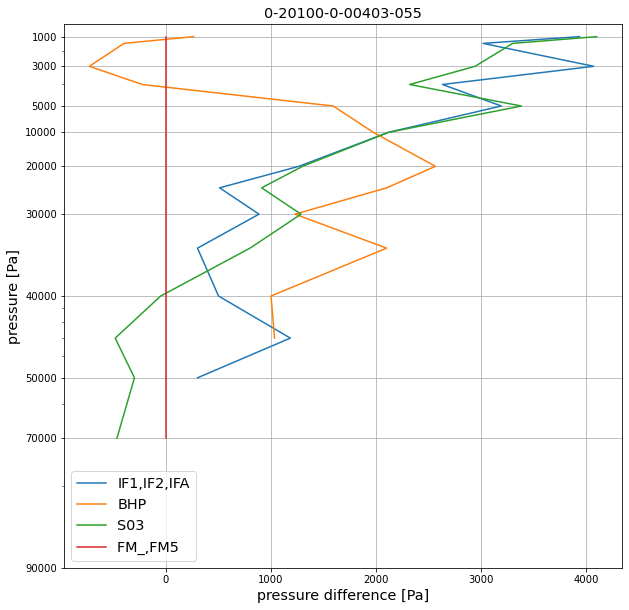

In [103]:
fig, (ax1) = plt.subplots(1)
yplevs = np.array([10,30,50,100,200,300,400,500,700,900])*100.
#             yplevs = np.flip(yplevs)
#     -
for r in pres_delta.keys():
    ax1.semilogy(pres_delta[r], pressure_list)
ax1.set(xlabel ='pressure difference [Pa]', ylabel='pressure [Pa]', title=picname, )
ax1.set_yticks(ticks=yplevs)
ax1.set_yticklabels(map("{:.0f}".format,np.flip(yplevs)),rotation='horizontal')
ax1.set_ylim(100000,1000)
ax1.legend(pres_delta.keys(), loc='best')
ax1.invert_yaxis()
ax1.grid()
plt.show()